In [113]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math

In [114]:
dtype = [
    ('record', 'U6'),
    ('atom_id', 'i4'),
    ('atom_name', 'U4'),
    ('res_name', 'U4'),
    ('res_id', 'i4'),
    ('x', 'f8'),
    ('y', 'f8'),
    ('z', 'f8'),
    ('occupancy', 'f8'),
    ('temp_factor', 'f8'),
    ('segment', 'U6')
]

In [115]:
def get_distinct_color(i, total):
    if total <= 20:
        cmap = plt.get_cmap('tab20', total)
        return cmap(i)
    elif total <= 40:
        if i < 20:
            cmap = plt.get_cmap('tab20', 20)
            return cmap(i)
        else:
            cmap = plt.get_cmap('tab20b', 20)
            return cmap(i-20)
    else:
        # fallback: hsv for many groups
        cmap = plt.get_cmap('hsv', total)
        return cmap(i)

In [116]:
data = np.genfromtxt(
    open('WaterBox.pdb', 'r'),
    dtype=dtype,
    autostrip=True
)

In [117]:
bisections = 2
bins_per_axis = bisections + 1
x_bins = bins_per_axis
y_bins = bins_per_axis
z_bins = bins_per_axis # Change to 1 for 2D
partitions = x_bins*y_bins*z_bins
box_size = 28.934
partition_size = box_size/bins_per_axis
print(f"Partition Size: {partition_size} cubic angstroms")
radius_from_center = 3.5

Partition Size: 9.644666666666668 cubic angstroms


In [118]:
def index_to_xyz(index):
    z = index // (x_bins * y_bins)
    remainder = index % (x_bins * y_bins)
    y = remainder // x_bins
    x = remainder % x_bins
    return [x, y, z]

In [119]:
def center_of_box(index):
    boxcoords = index_to_xyz(index)
    boxcentercoords = []
    for pos in boxcoords:
        boxcentercoords.append(round(((pos/bins_per_axis)*box_size + (box_size/bins_per_axis)/2), 2))
    return boxcentercoords

In [120]:
def distance3D(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2 + (coord1[2] - coord2[2])**2)

In [121]:
oxygens = data[data['atom_name'] == 'OH2']
for particle in oxygens:
    particle['x'] += box_size/2.0
    particle['y'] += box_size/2.0
    particle['z'] += box_size/2.0

In [122]:
boxes = [[] for i in range(partitions)]

In [123]:
for particle in oxygens:
    xID = int((particle['x']/box_size)/(1/(x_bins)))
    yID = int((particle['y']/box_size)/(1/(y_bins)))
    zID = int((particle['z']/box_size)/(1/(z_bins)))
    
    xID = min(max(xID, 0), x_bins - 1)
    yID = min(max(yID, 0), y_bins - 1)
    zID = min(max(zID, 0), z_bins - 1)
    boxIndex = xID + yID*x_bins + zID*x_bins*y_bins
    boxes[boxIndex].append(particle)

In [124]:
boxes = [np.array(b, dtype=dtype) for b in boxes]


In [ ]:
particles_near_center = []
for i, box in enumerate(boxes):
    count = 0
    center = center_of_box(i)
    for particle in box:
        if (distance3D((particle['x'], particle['y'], particle['z']), center) <= radius_from_center):
            count += 1
    particles_near_center.append(count)

hi


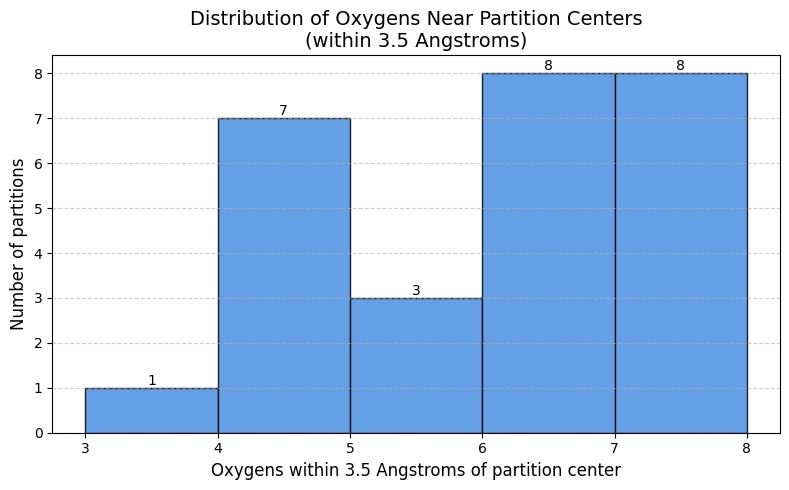

In [128]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)

n, bins, patches = ax.hist(
    particles_near_center,
    bins='auto',
    color='#4a90e2',
    edgecolor='black',
    alpha=0.85
)

ax.set_xlabel(f"Oxygens within {radius_from_center} Angstroms of partition center", fontsize=12)
ax.set_ylabel("Number of partitions", fontsize=12)
ax.set_title(f"Distribution of Oxygens Near Partition Centers\n(within {radius_from_center} Angstroms)", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.6)

for count, x in zip(n, bins[:-1]):
    if count > 0:
        ax.text(x + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom', fontsize=10)


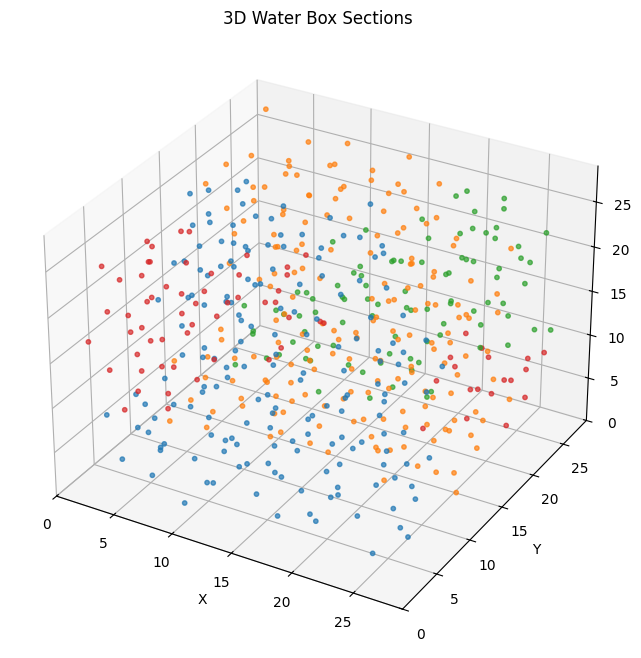

In [127]:
d = input("Dimentions? ")

if (d == "2"):
    ax = plt.figure(figsize=(8, 8)).add_subplot()

    colors = plt.get_cmap('tab10', partitions)

    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)

    for i, box in enumerate(boxes):
        if len(box) == 0:
            continue
        ax.scatter(box['x'], box['y'], color=get_distinct_color(i, partitions), label=f'Section {i+1}', s=10, alpha=0.7)

    ax.scatter(box['x'], box['y'], color=get_distinct_color(i, partitions), label=f'Section {i+1}', s=10, alpha=0.7)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('XY-Bisection')

    ax2 = plt.figure(figsize=(8, 8)).add_subplot()

    colors2 = plt.get_cmap('tab10', partitions)

    for i, box in enumerate(boxes):
        if len(box) == 0:
            continue
        ax2.scatter(box['x'], box['z'], color=get_distinct_color(i, partitions), label=f'Section {i+1}', s=10, alpha=0.7)

    ax2.set_xlabel('X')
    ax2.set_ylabel('Z')
    ax2.set_title('XZ-Bisection')
    # ax.legend()
else:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    ax.set_zlim(0, box_size)

    colors = plt.get_cmap('tab10', partitions)

    for i, box in enumerate(boxes):
        if len(box) == 0:
            continue
        ax.scatter(box['x'], box['y'], box['z'], color=colors(i % 10), label=f'Section {i+1}', s=10, alpha=0.7)
    '''
    boxindex = int(input("Box index? "))
    box = boxes[boxindex]
    print(index_to_xyz(boxindex))
    ax.scatter(box['x'], box['y'], box['z'], color=colors(i % 10), label=f'Section {i+1}', s=10, alpha=0.7)
    '''

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Water Box Sections')
    # ax.legend()